# 04 Insurance Draft

# Libraries

In [164]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier


import warnings
import shap
import optuna
import logging

## Display Features

In [55]:
%matplotlib inline
pd.options.display.max_rows = 300000
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 500
warnings.filterwarnings("ignore")

## Colors

In [56]:
color_1 = "bisque"
color_2 = "crimson"
color_3 = "orangered"
color_4 = "lightcoral"
color_5 = "royalblue"
color_6 = "pink"
color_7 = "indianred"
color_8 = "slategrey"
color_9 = "salmon"
color_10 = "beige"
color_11 = "coral"
color_13 = "grey"
color_14 = "tan"
color_15 = "wheat"
color_16 = "tomato"

## Figure Parameters

In [57]:
size = 20

params = {
    "font.family": "Times New Roman",
    "font.size": size,
    "axes.labelsize": size,
    "xtick.labelsize": size * 0.75,
    "ytick.labelsize": size * 0.75,
    "figure.titlesize": size * 1.5,
    "axes.titlesize": size * 1.5,
    "axes.titlepad": size,
    "axes.labelpad": size - 10,
    "lines.linewidth": 2,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": False,
    "axes.spines.bottom": False,
    "legend.fontsize": size,
}

# Standards

Below is a summary of the standards I followed and my assumptions related to this project. 

>* **Standard 1:** My standard for an acceptable accuracy Score for wins is 75%. <BR>

# Load Data

In [58]:
insurance = pd.read_csv(
    "C:\\Users\\Space\\Documents\\py\\Projects\\TuringCollege\\Insurance\\DataSet\\Insurance.csv",
    index_col=0,
)

# Data Overview and Preprocessing

In [59]:
insurance = insurance.rename(
    columns={
        "Employment Type": "EmploymentType",
        "GraduateOrNot": "Graduate",
        "EverTravelledAbroad": "TravelledAbroad",
    }
)

In [60]:
insurance.head()

Age                EmploymentType Graduate  AnnualIncome  FamilyMembers  \
0   31             Government Sector      Yes        400000              6   
1   31  Private Sector/Self Employed      Yes       1250000              7   
2   34  Private Sector/Self Employed      Yes        500000              4   
3   28  Private Sector/Self Employed      Yes        700000              3   
4   28  Private Sector/Self Employed      Yes        700000              8   

   ChronicDiseases FrequentFlyer TravelledAbroad  TravelInsurance  
0                1            No              No                0  
1                0            No              No                0  
2                1            No              No                1  
3                1            No              No                0  
4                1           Yes              No                0

In [61]:
insurance.shape[0]

1987

In [62]:
insurance.isnull().sum(axis=0)

Age                0
EmploymentType     0
Graduate           0
AnnualIncome       0
FamilyMembers      0
ChronicDiseases    0
FrequentFlyer      0
TravelledAbroad    0
TravelInsurance    0
dtype: int64

In [63]:
insurance.count()

Age                1987
EmploymentType     1987
Graduate           1987
AnnualIncome       1987
FamilyMembers      1987
ChronicDiseases    1987
FrequentFlyer      1987
TravelledAbroad    1987
TravelInsurance    1987
dtype: int64

In [64]:
insurance.dtypes

Age                 int64
EmploymentType     object
Graduate           object
AnnualIncome        int64
FamilyMembers       int64
ChronicDiseases     int64
FrequentFlyer      object
TravelledAbroad    object
TravelInsurance     int64
dtype: object

<Axes: xlabel='Age', ylabel='count'>

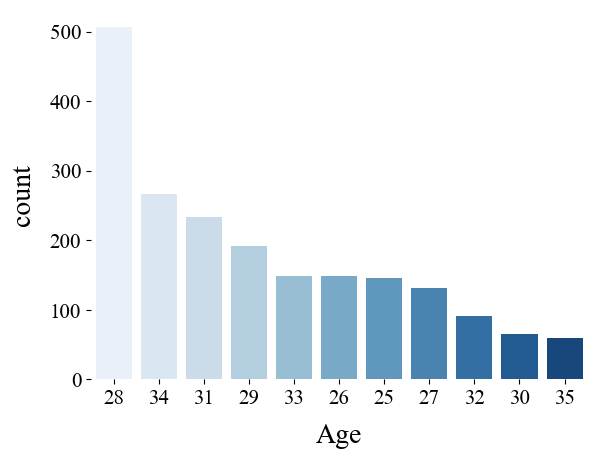

In [65]:
sns.countplot(
    x="Age",
    data=insurance,
    palette="Blues",
    order=insurance["Age"].value_counts().index,
)

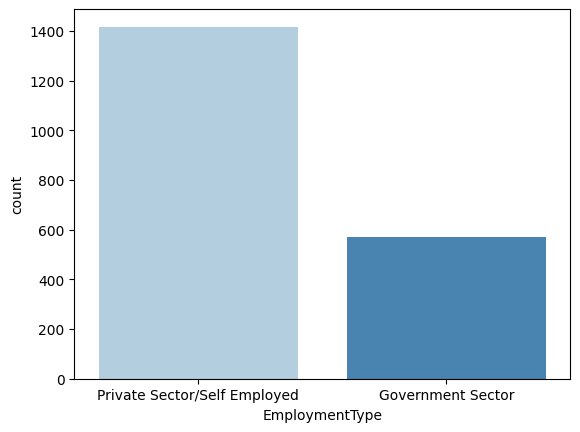

In [28]:
sns.countplot(
    x="EmploymentType",
    data=insurance,
    palette="Blues",
    order=insurance["EmploymentType"].value_counts().index,
)

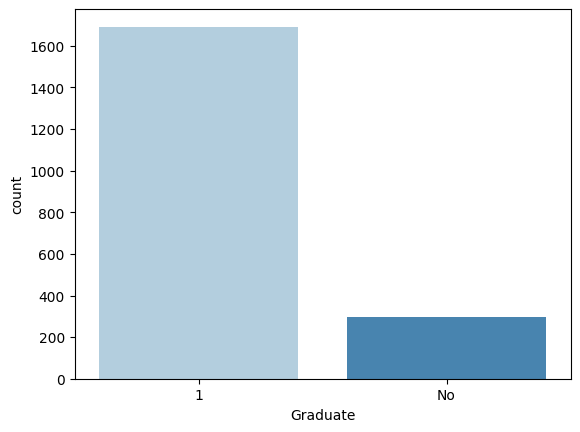

In [30]:
sns.countplot(
    x="Graduate",
    data=insurance,
    palette="Blues",
    order=insurance["Graduate"].value_counts().index,
)

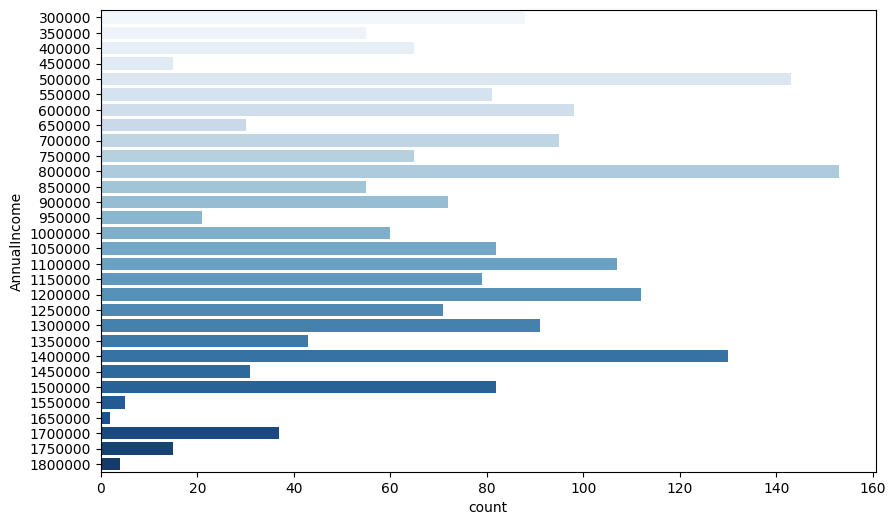

In [31]:
plt.figure(figsize=(10, 6))
sns.countplot(y="AnnualIncome", data=insurance, palette="Blues")

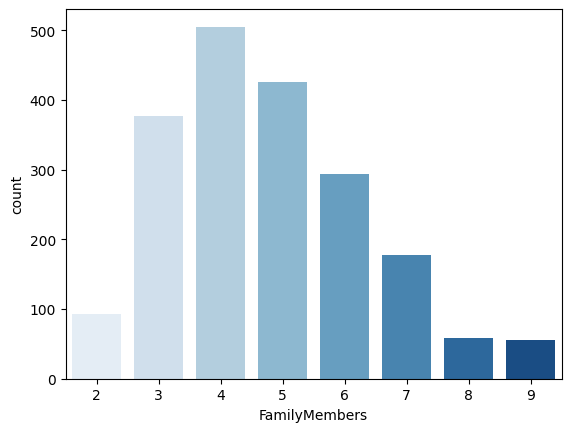

In [32]:
sns.countplot(x="FamilyMembers", data=insurance, palette="Blues")

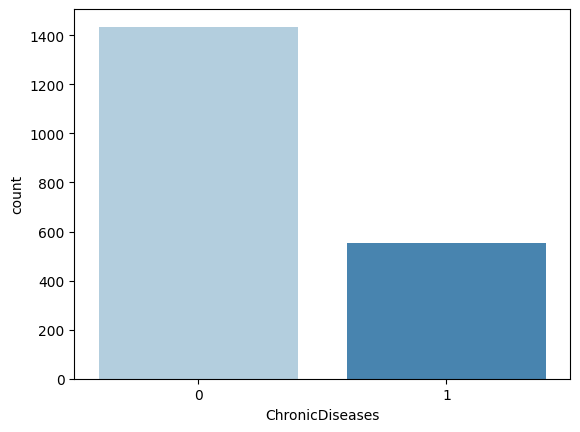

In [33]:
sns.countplot(x="ChronicDiseases", data=insurance, palette="Blues")

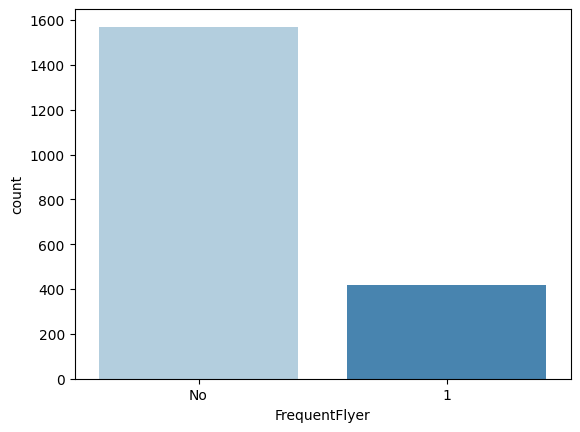

In [34]:
sns.countplot(x="FrequentFlyer", data=insurance, palette="Blues")

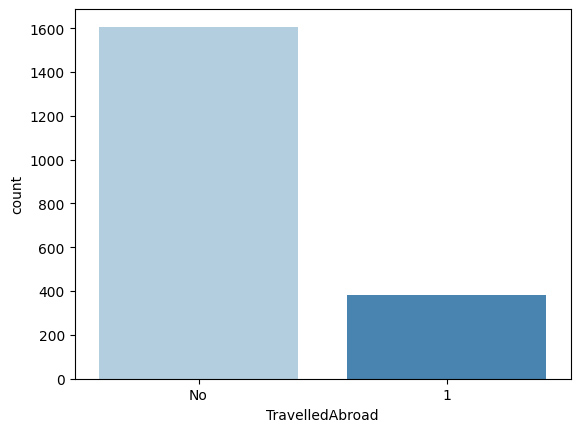

In [35]:
sns.countplot(x="TravelledAbroad", data=insurance, palette="Blues")

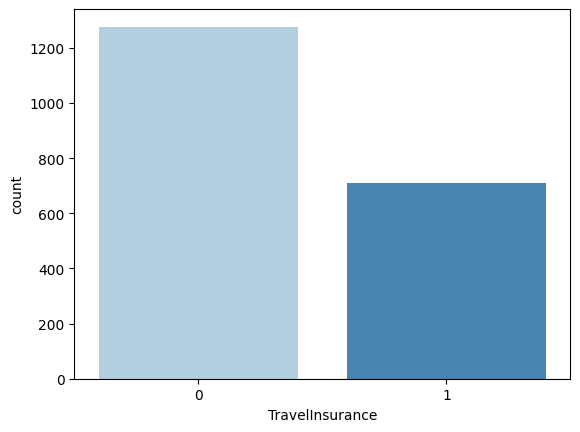

In [38]:
sns.countplot(x="TravelInsurance", data=insurance, palette="Blues");

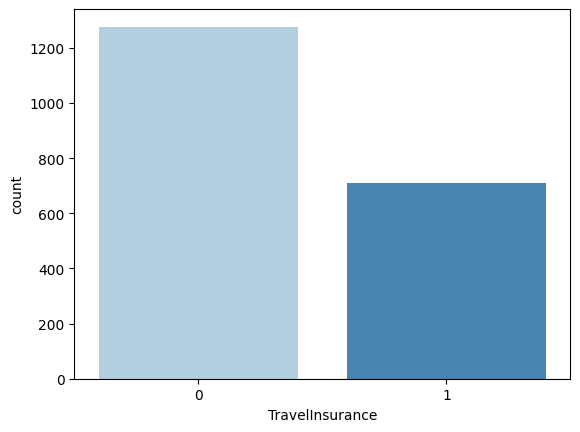

In [39]:
sns.countplot(
    x="TravelInsurance",
    data=insurance,
    palette="Blues",
    order=insurance["TravelInsurance"].value_counts().index,
);

# Correlations

In [40]:
def create_heatmap(data, title):
    """
    Creates a Seaborn heatmap.
    """

    plt.rcParams.update(params)
    corr = data.corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))

    f, ax = plt.subplots(figsize=(10, 15))

    cmap = sns.diverging_palette(230, 10, as_cmap=True)
    heatmap = sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmax=1,
        vmin=-1,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        annot=True,
    )

    heatmap.set_title(
        title,
        fontdict={"fontsize": size},
        pad=12,
    )
    plt.xlabel("")
    plt.ylabel("")

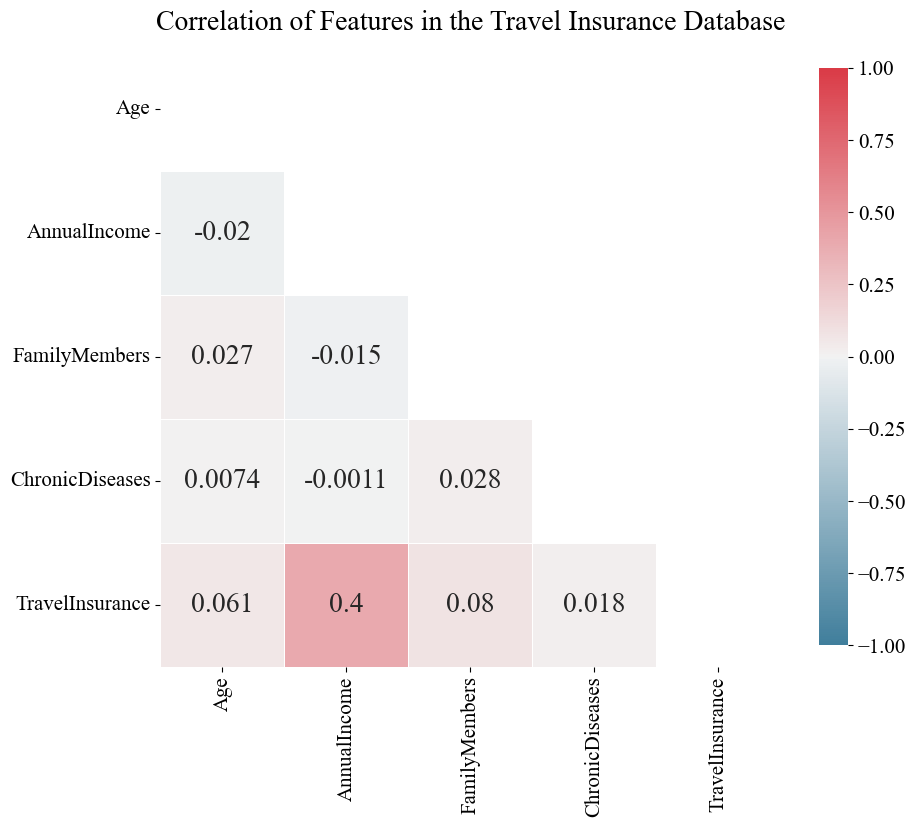

In [41]:
data = insurance
title = "Correlation of Features in the Travel Insurance Database"
create_heatmap(data, title)

In [42]:
corr_matrix = insurance.corr(numeric_only=True)
corr_matrix["TravelInsurance"].sort_values(ascending=False)

TravelInsurance    1.000000
AnnualIncome       0.396763
FamilyMembers      0.079909
Age                0.061060
ChronicDiseases    0.018190
Name: TravelInsurance, dtype: float64

# Machine Learning

In [147]:
label_encoder = LabelEncoder()
obj = (insurance.dtypes == 'object')

for col in list(obj[obj].index):
    insurance[col] = label_encoder.fit_transform(insurance[col])

In [148]:
X = insurance.drop("TravelInsurance", axis=1)
y = insurance["TravelInsurance"]

In [149]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101
)

# Logistic Regression

In [150]:
logisticregression = LogisticRegression()
logisticregression.fit(X_train, y_train);

In [151]:
y_predict = logisticregression.predict(X_test)

In [152]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       258
           1       0.00      0.00      0.00       140

    accuracy                           0.65       398
   macro avg       0.32      0.50      0.39       398
weighted avg       0.42      0.65      0.51       398



In [ ]:
plot_confusion_matrix(logisticregression, X_test, y_test, cmap=plt.cm.Blues)
plt.xticks([0, 1], ["Yes", "No"])
plt.yticks([0, 1], ["Yes", "No"])

# Decision Tree

In [157]:
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train, y_train);

In [158]:
y_predict = decisiontree.predict(X_test)

In [159]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       258
           1       0.68      0.61      0.64       140

    accuracy                           0.76       398
   macro avg       0.74      0.73      0.73       398
weighted avg       0.76      0.76      0.76       398



In [ ]:
plot_confusion_matrix(decisiontree, X_test, y_test, cmap=plt.cm.Blues)
plt.xticks([0, 1], ["Yes", "No"])
plt.yticks([0, 1], ["Yes", "No"])

# KNN

In [153]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train);

In [155]:
y_predict = knn.predict(X_test)

In [156]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       258
           1       0.78      0.65      0.71       140

    accuracy                           0.81       398
   macro avg       0.81      0.78      0.79       398
weighted avg       0.81      0.81      0.81       398



In [ ]:
plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues)
plt.xticks([0, 1], ["Yes", "No"])
plt.yticks([0, 1], ["Yes", "No"])

# SHAP

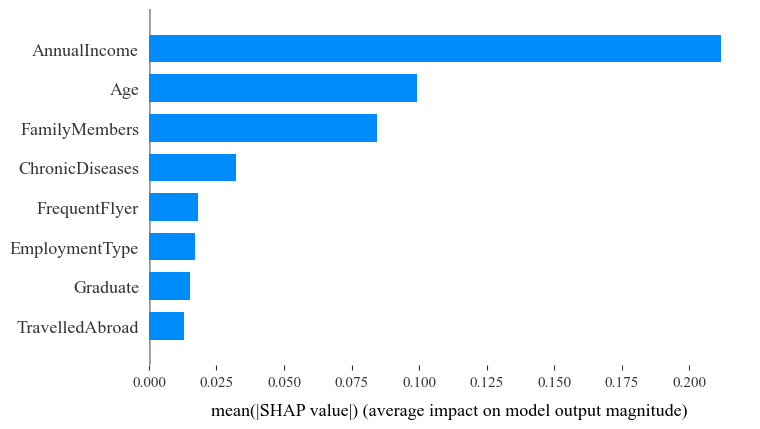

In [165]:
# Initialize the explainer with the training data
explainer = shap.TreeExplainer(decisiontree)

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[0], X_test, plot_type="bar")
plt.show()

# Decision Tree with Backward Elimination 

In [146]:
# Get feature importances
importances = model.feature_importances_

# Loop over feature importances and remove least significant feature
while np.any(importances < 0.01):
    # Get index of least significant feature
    index_to_remove = np.argmin(importances)
    
    # Remove feature from X_train and X_test
    X_train = X_train.drop(X_train.columns[index_to_remove], axis=1)
    X_test = X_test.drop(X_test.columns[index_to_remove], axis=1)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get feature importances
    importances = model.feature_importances_
    
    # Evaluate the model on the test data
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Removed feature {index_to_remove}. New accuracy: {accuracy:.3f}')

# Decision Tree with SHAP

In [81]:
X = insurance[["AnnualIncome", "Age", "FamilyMembers"]]

In [82]:
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train, y_train);

In [83]:
y_predict = decisiontree.predict(X_test)

In [84]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       258
           1       0.71      0.61      0.66       140

    accuracy                           0.78       398
   macro avg       0.76      0.74      0.75       398
weighted avg       0.77      0.78      0.77       398



In [ ]:
plot_confusion_matrix(decisiontree, X_test, y_test, cmap=plt.cm.Blues)
plt.xticks([0, 1], ["Yes", "No"])
plt.yticks([0, 1], ["Yes", "No"])

# Decision Tree with Optuna

In [107]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def decisiontree_optuna(trial):

    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    splitter = trial.suggest_categorical("splitter", ["best", "random"])
    max_depth = trial.suggest_int("max_depth", 1, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    model = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=0,
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [108]:
study = optuna.create_study(direction="maximize")
study.optimize(decisiontree_optuna, n_trials=100)

In [109]:
print(f"Best Accuracy Score: {study.best_value:.5f}")
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Best Accuracy Score: 0.82663
Best hyperparameters:
	criterion: gini
	splitter: best
	max_depth: 6
	min_samples_split: 5
	min_samples_leaf: 3


In [111]:
best_params = study.best_params

model = DecisionTreeClassifier(
    criterion=best_params["criterion"],
    splitter=best_params["splitter"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    random_state=0,
)
model.fit(X_train, y_train);

In [112]:
y_predict = model.predict(X_test)

In [113]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88       258
           1       0.94      0.54      0.69       140

    accuracy                           0.83       398
   macro avg       0.87      0.76      0.78       398
weighted avg       0.85      0.83      0.81       398



In [ ]:
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
plt.xticks([0, 1], ["Yes", "No"])
plt.yticks([0, 1], ["Yes", "No"])